# Fake Review Detector


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from sklearn.pipeline import FeatureUnion
import pickle


In [14]:
try:
    df = pd.read_csv("fake reviews dataset.csv")
except UnicodeDecodeError:
    df = pd.read_csv("fake reviews dataset.csv", encoding="latin-1")

df.head()


,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


In [15]:
expected = ['category', 'rating', 'label', 'text_']
missing = [c for c in expected if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns in CSV: {missing}. Found: {list(df.columns)}")

df = df[expected].copy()
df['text_'] = df['text_'].astype(str)
df['label'] = df['label'].astype(str).str.strip()

df['label'].value_counts()


label
CG    20216
OR    20216
Name: count, dtype: int64

In [16]:
df.rename(columns={'label': 'target', 'text_': 'text'}, inplace=True)

df['target'].value_counts(), df[['text','target']].head()


(target
 CG    20216
 OR    20216
 Name: count, dtype: int64,
                                                 text target
 0  Love this!  Well made, sturdy, and very comfor...     CG
 1  love it, a great upgrade from the original.  I...     CG
 2  This pillow saved my back. I love the look and...     CG
 3  Missing information on how to use it, but it i...     CG
 4  Very nice set. Good quality. We have had the s...     CG)

In [17]:
df['num_characters'] = df['text'].apply(len)
df['num_words'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))
df['num_sentences'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))

df[['num_characters','num_words','num_sentences']].describe()


,num_characters,num_words,num_sentences
count,40432.000000,40432.000000,40432.000000
mean,351.271963,76.671003,5.276143
std,369.813570,79.230384,4.914112
min,24.000000,2.000000,1.000000
25%,107.000000,24.000000,2.000000
50%,198.000000,44.000000,3.000000
75%,439.000000,96.000000,6.000000
max,2827.000000,510.000000,133.000000


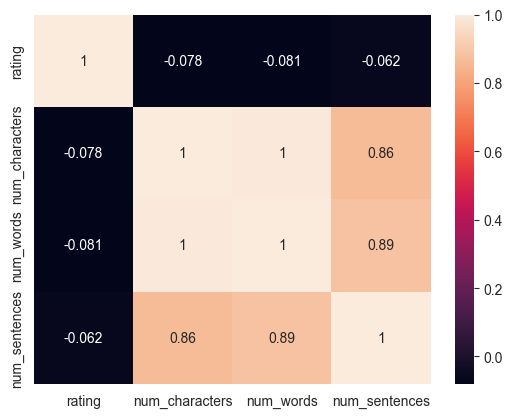

In [18]:
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True)
plt.show()


In [19]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
import nltk

ps = PorterStemmer()
STOPWORDS = set(stopwords.words("english"))
PUNCT = set(string.punctuation)

def transform_text(text):
    text = str(text).lower()
    tokens = nltk.word_tokenize(text)

    y = []
    for t in tokens:
        if t.isalnum() and t not in STOPWORDS and t not in PUNCT:
            y.append(ps.stem(t))

    return " ".join(y)

df["transformed_text"] = df["text"].astype(str).apply(transform_text)
df[['text','transformed_text']].head()


,text,transformed_text
0,"Love this! Well made, sturdy, and very comfor...",love well made sturdi comfort love pretti
1,"love it, a great upgrade from the original. I...",love great upgrad origin mine coupl year
2,This pillow saved my back. I love the look and...,pillow save back love look feel pillow
3,"Missing information on how to use it, but it i...",miss inform use great product price
4,Very nice set. Good quality. We have had the s...,nice set good qualiti set two month


In [20]:
X = df[['transformed_text', 'num_characters', 'num_words', 'num_sentences']].copy()
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2, stratify=y
)

X_train.head()


,transformed_text,num_characters,num_words,num_sentences
39397,amazon author kendra shoe store decid purchas ...,257,59,4
30342,good book took awhil start second time never p...,242,54,4
27009,love militari fiction particularli stori full ...,548,112,6
5310,quick instal easi use also use first bought fr...,105,23,2
6234,paracord shackl style bracelet brother ten yea...,135,29,3


In [21]:
word_tfidf = TfidfVectorizer(max_features=3000)
char_tfidf = TfidfVectorizer(analyzer='char', ngram_range=(3,5), max_features=3000)

text_union = FeatureUnion([
    ('word', word_tfidf),
    ('char', char_tfidf)
])

preprocess = ColumnTransformer(
    transformers=[
        ('text', text_union, 'transformed_text'),
        ('num', 'passthrough', ['num_characters', 'num_words', 'num_sentences'])
    ],
    remainder='drop'
)

pipe = Pipeline([
    ('preprocess', preprocess),
    ('clf', LogisticRegression(
        solver='liblinear',
        max_iter=1000,
        class_weight='balanced'
    ))
])

pipe.fit(X_train, y_train)

# Evaluate
y_pred = pipe.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (CG positive):", precision_score(y_test, y_pred, pos_label='CG', zero_division=0))
print("Recall (CG):", recall_score(y_test, y_pred, pos_label='CG', zero_division=0))
print("F1 (CG):", f1_score(y_test, y_pred, pos_label='CG', zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred, zero_division=0))


Accuracy: 0.8850006182762459
Precision (CG positive): 0.8788321167883212
Recall (CG): 0.8931750741839762
F1 (CG): 0.8859455481972038
Confusion Matrix:
 [[3612  432]
 [ 498 3545]]

Classification report:
               precision    recall  f1-score   support

          CG       0.88      0.89      0.89      4044
          OR       0.89      0.88      0.88      4043

    accuracy                           0.89      8087
   macro avg       0.89      0.88      0.88      8087
weighted avg       0.89      0.89      0.88      8087



In [24]:
from sklearn.metrics import accuracy_score, precision_score
import json

y_pred = pipe.predict(X_test)

metrics = {
    "accuracy": float(accuracy_score(y_test, y_pred)),
    "precision_CG": float(precision_score(y_test, y_pred, pos_label="CG", zero_division=0))
}

with open("model_metrics.json", "w") as f:
    json.dump(metrics, f)

print("Saved model_metrics.json:", metrics)

Saved model_metrics.json: {'accuracy': 0.8850006182762459, 'precision_CG': 0.8788321167883212}


In [22]:
pickle.dump(pipe, open("fake_reviews_pipe.pkl", "wb"))
print("Saved fake_reviews_pipe.pkl")


Saved fake_reviews_pipe.pkl


In [23]:
def featurize_single_review(raw_text: str):
    raw_text = str(raw_text)
    return pd.DataFrame([{
        'transformed_text': transform_text(raw_text),
        'num_characters': len(raw_text),
        'num_words': len(nltk.word_tokenize(raw_text)),
        'num_sentences': len(nltk.sent_tokenize(raw_text))
    }])

sample = "Best product ever!!! Totally worth it, buy now!!!"
pipe.predict(featurize_single_review(sample))[0]


'OR'